# VoxelMorph
### `IABI Course, Dr. Rohban`
#### Homework 4
*`Full Name:`* Alireza Sabounchi

*`SID:`* 401212454

## Proposed Method Description
$\href {https://arxiv.org/pdf/1809.05231}{Voxelmorph}$ framework, which is designed for image registration using deep learning. Image registration is the process of aligning different images into a common coordinate system. Voxelmorph leverages unsupervised learning to register images by minimizing a loss function that reflects spatial correspondence between images.

Voxelmorph employs a convolutional neural network to predict a deformation field that maps one image to another. The deformation field represents how the pixels in one image should be displaced to align with another image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
import time
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.normal import Normal
from torch.autograd import Variable
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import math

!pip install monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.apps import MedNISTDataset
import tempfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.9 MB/s eta 0:00:00


# DATALOADER

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#inst

MedNIST.tar.gz: 59.0MB [00:02, 24.8MB/s]                            

2025-01-02 10:19:10,198 - INFO - Downloaded: /tmp/tmpuhftl50a/MedNIST.tar.gz
2025-01-02 10:19:10,306 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-01-02 10:19:10,307 - INFO - Writing into directory: /tmp/tmpuhftl50a.



Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 107283.44it/s]



 first training items:  [{'fixed_hand': '/tmp/tmpuhftl50a/MedNIST/Hand/002818.jpeg', 'moving_hand': '/tmp/tmpuhftl50a/MedNIST/Hand/002818.jpeg'}, {'fixed_hand': '/tmp/tmpuhftl50a/MedNIST/Hand/009530.jpeg', 'moving_hand': '/tmp/tmpuhftl50a/MedNIST/Hand/009530.jpeg'}, {'fixed_hand': '/tmp/tmpuhftl50a/MedNIST/Hand/007427.jpeg', 'moving_hand': '/tmp/tmpuhftl50a/MedNIST/Hand/007427.jpeg'}]
moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


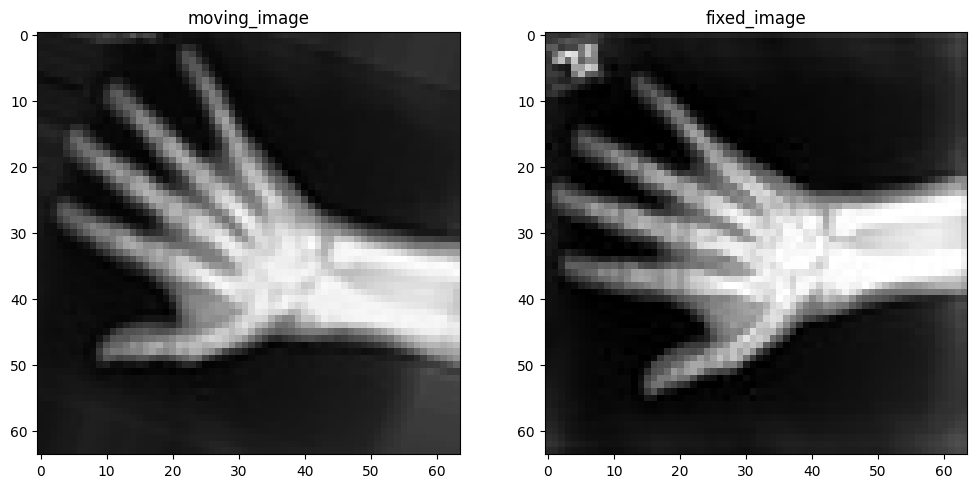

Loading dataset: 100%|██████████| 500/500 [00:00<00:00, 509.44it/s]


In [2]:
# DO NOT CHANGE THIS CELL



print_config()
set_determinism(42)
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)


train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data
    if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])

train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"]),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRanged(
            keys=["fixed_hand", "moving_hand"],
            a_min=0.0,
            a_max=255.0,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RandRotateD(keys=["moving_hand"], range_x=np.pi / 4, prob=1.0, keep_size=True, mode="bicubic"),
        RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
    ]
)

check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed_hand"][0][0]
moving_image = check_data["moving_hand"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()


train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)

# U-NET

`Encoder-Decoder Network`: The model takes two images as input: a moving image and a fixed image. It outputs the deformation field that aligns the moving image to the fixed one.

<p align="left">
<img src="https://drive.usercontent.google.com/u/0/uc?id=14S29efIg5RZsZ7b0Mm9ucWLKUagVn0N5&export=download" alt="" width="500"/>
</p>

The Voxelmorph model consists of a convolutional encoder-decoder architecture:
- Encoder: Extracts features from the input images using convolutions and pooling layers.
- Decoder: Upsamples the encoded features to generate the deformation field that aligns the images.
- Flow Field: The final output is a deformation field.
Input/Output: 

In [3]:
# DO NOT CHANGE THIS CELL


class Unet(nn.Module):
    """
    A unet architecture. Layer features can be specified directly as a list of encoder and decoder
    features or as a single integer along with a number of unet levels. The default network features
    per layer (when no options are specified) are:

        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]
    """

    def __init__(self,
                 inshape=None,
                 infeats=None,
                 nb_features=None,
                 nb_levels=None,
                 max_pool=2,
                 feat_mult=1,
                 nb_conv_per_level=1,
                 half_res=False):
        """
        Parameters:
            inshape: Input shape. e.g. (1, 64, 64)
            infeats: Number of input features.
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. 
                If None (default), the unet features are defined by the default config described in 
                the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer. 
                Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. 
                Default is 1.
            nb_conv_per_level: Number of convolutions per unet level. Default is 1.
            half_res: Skip the last decoder upsampling. Default is False.
        """

        super().__init__()

        # ensure correct dimensionality
        ndims = 2

        # cache some parameters
        self.half_res = half_res

        # default encoder and decoder layer features if nothing provided
        if nb_features is None:
            nb_features = default_unet_features()

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            nb_features = [
                np.repeat(feats[:-1], nb_conv_per_level),
                np.repeat(np.flip(feats), nb_conv_per_level)
            ]
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')

        # extract any surplus (full resolution) decoder convolutions
        enc_nf, dec_nf = nb_features
        nb_dec_convs = len(enc_nf)
        final_convs = dec_nf[nb_dec_convs:]
        dec_nf = dec_nf[:nb_dec_convs]
        self.nb_levels = int(nb_dec_convs / nb_conv_per_level) + 1

        if isinstance(max_pool, int):
            max_pool = [max_pool] * self.nb_levels

        # cache downsampling / upsampling operations
        MaxPooling = getattr(nn, 'MaxPool%dd' % ndims)
        self.pooling = [MaxPooling(s) for s in max_pool]
        self.upsampling = [nn.Upsample(scale_factor=s, mode='nearest') for s in max_pool]

        # configure encoder (down-sampling path)
        prev_nf = infeats
        encoder_nfs = [prev_nf]
        self.encoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = enc_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.encoder.append(convs)
            encoder_nfs.append(prev_nf)

        # configure decoder (up-sampling path)
        encoder_nfs = np.flip(encoder_nfs)
        self.decoder = nn.ModuleList()
        for level in range(self.nb_levels - 1):
            convs = nn.ModuleList()
            for conv in range(nb_conv_per_level):
                nf = dec_nf[level * nb_conv_per_level + conv]
                convs.append(ConvBlock(ndims, prev_nf, nf))
                prev_nf = nf
            self.decoder.append(convs)
            if not half_res or level < (self.nb_levels - 2):
                prev_nf += encoder_nfs[level]

        # now we take care of any remaining convolutions
        self.remaining = nn.ModuleList()
        for num, nf in enumerate(final_convs):
            self.remaining.append(ConvBlock(ndims, prev_nf, nf))
            prev_nf = nf

        # cache final number of features
        self.final_nf = prev_nf

    def forward(self, x):

        # encoder forward pass
        x_history = [x]
        for level, convs in enumerate(self.encoder):
            for conv in convs:
                x = conv(x)
            x_history.append(x)
            x = self.pooling[level](x)

        # decoder forward pass with upsampling and concatenation
        for level, convs in enumerate(self.decoder):
            for conv in convs:
                x = conv(x)
            if not self.half_res or level < (self.nb_levels - 2):
                x = self.upsampling[level](x)
                x = torch.cat([x, x_history.pop()], dim=1)

        # remaining convs at full resolution
        for conv in self.remaining:
            x = conv(x)

        return x


class VxmDense(nn.Module):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    def __init__(self,
                 inshape,
                 nb_unet_features=None,
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 nb_unet_conv_per_level=1,
                 int_steps=7,
                 int_downsize=2,
                 use_probs=False,
                 src_feats=1,
                 trg_feats=1,
                 unet_half_res=False):
        """ 
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. 
                If None (default), the unet features are defined by the default config described in 
                the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_features is an integer. 
                Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. 
                Default is 1.
            nb_unet_conv_per_level: Number of convolutions per unet level. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this 
                value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration. 
                The flow field is not downsampled when this value is 1.
            use_probs: Use probabilities in flow field. Default is False.
            src_feats: Number of source image features.
            trg_feats: Number of target image features.
            unet_half_res: Skip the last unet decoder upsampling. Requires that int_downsize=2. 
                Default is False.
        """
        super().__init__()

        # internal flag indicating whether to return flow or integrated warp during inference
        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            infeats=(src_feats + trg_feats),
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult,
            nb_conv_per_level=nb_unet_conv_per_level,
            half_res=unet_half_res,
        )

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.flow = Conv(self.unet_model.final_nf, ndims, kernel_size=3, padding=1)

        # init flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        # probabilities are not supported in pytorch
        if use_probs:
            raise NotImplementedError(
                'Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure optional resize layers (downsize)
        if not unet_half_res and int_steps > 0 and int_downsize > 1:
            self.resize = ResizeTransform(int_downsize, ndims)
        else:
            self.resize = None

        # resize to full res
        if int_steps > 0 and int_downsize > 1:
            self.fullsize = ResizeTransform(1 / int_downsize, ndims)
        else:
            self.fullsize = None


        # configure optional integration layer for diffeomorphic warp
        down_shape = [int(dim / int_downsize) for dim in inshape]
        self.integrate = VecInt(down_shape, int_steps) if int_steps > 0 else None

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, source, target, registration=False):
        '''
        Parameters:
            source: Source image tensor.
            target: Target image tensor.
            registration: Return transformed image and flow. Default is False.
        '''

        # concatenate inputs and propagate unet
        x = torch.cat([source, target], dim=1)
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        # resize flow for integration
        pos_flow = flow_field
        if self.resize:
            pos_flow = self.resize(pos_flow)

        preint_flow = pos_flow

        # integrate to produce diffeomorphic warp
        if self.integrate:
            pos_flow = self.integrate(pos_flow)

            # resize to final resolution
            if self.fullsize:
                pos_flow = self.fullsize(pos_flow)

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)

        # return non-integrated flow field if training
        if not registration:
            return  y_source, preint_flow
        else:
            return y_source, pos_flow


class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.main(x)
        out = self.activation(out)
        return out

import torch
import torch.nn as nn
import torch.nn.functional as nnf


class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nnf.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


class VecInt(nn.Module):
    """
    Integrates a vector field via scaling and squaring.
    """

    def __init__(self, inshape, nsteps):
        super().__init__()

        assert nsteps >= 0, 'nsteps should be >= 0, found: %d' % nsteps
        self.nsteps = nsteps
        self.scale = 1.0 / (2 ** self.nsteps)
        self.transformer = SpatialTransformer(inshape)

    def forward(self, vec):
        vec = vec * self.scale
        for _ in range(self.nsteps):
            vec = vec + self.transformer(vec, vec)
        return vec


class ResizeTransform(nn.Module):
    """
    Resize a transform, which involves resizing the vector field *and* rescaling it.
    """

    def __init__(self, vel_resize, ndims):
        super().__init__()
        self.factor = 1.0 / vel_resize
        self.mode = 'linear'
        if ndims == 2:
            self.mode = 'bi' + self.mode
        elif ndims == 3:
            self.mode = 'tri' + self.mode

    def forward(self, x):
        if self.factor < 1:
            # resize first to save memory
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)
            x = self.factor * x

        elif self.factor > 1:
            # multiply first to save memory
            x = self.factor * x
            x = nnf.interpolate(x, align_corners=True, scale_factor=self.factor, mode=self.mode)

        return x


# LOSS

The loss function is crucial for training the network and ensures that the predicted deformation aligns the moving image with the fixed image.
The Voxelmorph paper defines two components for the loss:
### Similarity Loss:
`MSE Loss`: This term quantifies how well the aligned images match in terms of pixel intensities.

`Cross correlation loss`: This term quantifies how well the aligned images match in terms of pixel intensities.

<p align="left">
<img src="https://drive.usercontent.google.com/u/0/uc?id=1k1Erq2g06KeAA_P5oj807oBxZ2icGSXy&export=download" alt="" width="500"/>
</p>

### Smooth Loss
`Smoothness Loss (Regularization Loss)`: To prevent unrealistic deformations, the deformation field is regularized to encourage smooth transformations.

$
L_{\text{smooth}}(\mathbf{\phi}) = \sum_{p \in \Omega} \|\nabla \mathbf{p}\|^2
$

This loss penalizes high-frequency deformations, ensuring that the transformation is smooth and continuous.

Total Loss: The total loss is a weighted sum of the image matching loss and the smoothness los

$L_{total} =  L_{similarity} + \lambda \cdot L_{smooth}$
 
where λ is a regularization weight controlling the trade-off between matching the images and enforcing smooth deformation


` Dice Score `:

<p align="left">
<img src="https://drive.usercontent.google.com/u/0/uc?id=1Bb_K1GYhFY8b5rmobZ9FwTHpxrMEZFhl&export=download" alt="" width="500"/>
</p>


## TO DO
You should complete each Loss function based on the description on the `VoxelMorph paper`.

In [4]:
def cross_correlation_loss_OR_MSE(y_true, y_pred):
    #################################################################################
    #                         YOUR CODE GOES HERE                   30 pts          #
    # MSE Loss
    mse_loss = F.mse_loss(y_pred, y_true)
    
    # Cross-Correlation Loss
    def cc(y_true, y_pred):
        y_true_mean = torch.mean(y_true)
        y_pred_mean = torch.mean(y_pred)
        nom = torch.sum((y_true-y_true_mean)*(y_pred-y_pred_mean))
        denom = torch.sqrt(torch.sum((y_true-y_true_mean)**2)*torch.sum((y_pred-y_pred_mean)**2))
        #print('Cross Corr is:', -nom/(denom+1e-6))
        return -nom/(denom+1e-6)
    cc_loss = cc(y_true, y_pred)
    
    # return mse_loss
    return cc_loss
    #################################################################################
     



def smoothing_loss(y_pred):
    #################################################################################
    #                         YOUR CODE GOES HERE                   20 pts          #
    # Gradients approx
    dy = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
    dx = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]


    loss = (dx**2).mean()+(dy**2).mean()
    return loss
    #################################################################################
def dice_score(target, pred):
    #################################################################################
    #                         YOUR CODE GOES HERE        15 pts                     #
    batch_size = target.size(0)
    dice = 0
    for i in range(batch_size):
        nom = torch.sum(target[i]*pred[i])
        denom = torch.sum(target[i])+torch.sum(pred[i])
        dice += (2*nom+1e-6)/(denom+1e-6)
    return dice/batch_size
    #################################################################################

In [5]:
class VoxelLoss(nn.Module):
  def __init__(self):
    super(VoxelLoss, self).__init__()
  def forward(self, true, pred, dff):
    #################################################################################
    #                         YOUR CODE GOES HERE               5 pts              #
    cor = cross_correlation_loss_OR_MSE(true, pred)
    smooth = smoothing_loss(dff)
    return   cor + 1.0 * smooth  # Lambda value based on paper
    #################################################################################

criterion = VoxelLoss()

# TRAIN

In [6]:
# DO NOT CHANGE THIS CELL

inshape=[64,64]
enc_nf =  [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

voxelmorph = VxmDense(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(voxelmorph.parameters(), lr=1e-5)
voxelmorph = voxelmorph.to(device)

num_epochs = 20 # You can change number of epochs

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
# TODO

train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
best_val_loss = float('inf') 
best_val_dice_score = float('inf') 
best_model_wts = None

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss, train_dice_score, val_loss, val_dice_score = 0, 0, 0, 0
    num_train_batches, num_val_batches = len(train_loader), len(val_loader)

    voxelmorph.train()
    train_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training')
    #################################################################################
    #                         YOUR CODE GOES HERE               12 pts              #

    for batch in train_loader_tqdm:
        batch_fixed, batch_moving = batch['fixed_hand'].to(device), batch['moving_hand'].to(device)
 
        optimizer.zero_grad()

        pred, dff = voxelmorph(batch_moving, batch_fixed)

        loss = criterion(batch_fixed, pred, dff)
        loss.backward()
        optimizer.step()

        dice = dice_score(batch_fixed, pred)

        train_loss += loss.item()
        train_dice_score += dice.item()
        # Progress Bar
        train_loader_tqdm.set_postfix(loss=train_loss/(train_loader_tqdm.n+1), dice=train_dice_score/(train_loader_tqdm.n+1))
        train_loader_tqdm.update()

    #################################################################################
    train_loss /= num_train_batches
    train_dice_score /= num_train_batches
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice_score)

    # Validation Phase
    voxelmorph.eval()
    val_loss = 0
    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation')
    with torch.no_grad():
         #################################################################################
         #                         YOUR CODE GOES HERE               8 pts              #
        for batch in val_loader_tqdm:
            batch_fixed, batch_moving = batch['fixed_hand'].to(device), batch['moving_hand'].to(device)

            pred, dff = voxelmorph(batch_moving, batch_fixed)

            loss = criterion(batch_fixed, pred, dff)

            dice = dice_score(batch_fixed, pred)

            val_loss += loss.item()
            val_dice_score += dice.item()

            # Return a full batch for visualization because last batch is not complete!
            if batch_fixed.shape[0] == 16: 
                pred_full, dff_full = voxelmorph(batch_fixed, batch_moving)
                batch_fixed_full, batch_moving_full = batch_fixed, batch_moving
        #################################################################################
            # Update progress bar
            val_loader_tqdm.set_postfix(val_loss=val_loss / (val_loader_tqdm.n + 1))
            val_loader_tqdm.update()

    val_loss /= num_val_batches
    val_dice_score /= num_val_batches
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice_score)
 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = voxelmorph.state_dict()
        best_val_dice_score = val_dice_score

    # Print epoch summary
    epoch_duration = (time.time() - epoch_start_time) / 60
    print(f"Epoch {epoch + 1}/{num_epochs} - Duration: {epoch_duration:.2f} mins - Train Loss: {train_loss:.3f}, Train DICE: {train_dice_score:.3f}, Val Loss: {val_loss:.3f}, Val DICE: {val_dice_score:.3f}")
    

Epoch 1/20 - Training:   0%|          | 0/63 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.91it/s, val_loss=-0.439]


Epoch 1/20 - Duration: 0.33 mins - Train Loss: -0.567, Train DICE: 0.471, Val Loss: -0.548, Val DICE: 0.464


Epoch 2/20 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, val_loss=-0.432]


Epoch 2/20 - Duration: 0.31 mins - Train Loss: -0.551, Train DICE: 0.465, Val Loss: -0.554, Val DICE: 0.467


Epoch 3/20 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.43it/s, val_loss=-0.441]


Epoch 3/20 - Duration: 0.32 mins - Train Loss: -0.561, Train DICE: 0.468, Val Loss: -0.551, Val DICE: 0.465


Epoch 4/20 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.51it/s, val_loss=-0.43]


Epoch 4/20 - Duration: 0.32 mins - Train Loss: -0.551, Train DICE: 0.464, Val Loss: -0.538, Val DICE: 0.460


Epoch 5/20 - Validation: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s, val_loss=-0.446]


Epoch 5/20 - Duration: 0.37 mins - Train Loss: -0.561, Train DICE: 0.467, Val Loss: -0.557, Val DICE: 0.466


Epoch 6/20 - Validation: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s, val_loss=-0.432]


Epoch 6/20 - Duration: 0.34 mins - Train Loss: -0.565, Train DICE: 0.468, Val Loss: -0.540, Val DICE: 0.458


Epoch 7/20 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s, val_loss=-0.436]


Epoch 7/20 - Duration: 0.34 mins - Train Loss: -0.565, Train DICE: 0.468, Val Loss: -0.546, Val DICE: 0.462


Epoch 8/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, val_loss=-0.441]


Epoch 8/20 - Duration: 0.33 mins - Train Loss: -0.569, Train DICE: 0.469, Val Loss: -0.551, Val DICE: 0.464


Epoch 9/20 - Validation: 100%|██████████| 32/32 [00:09<00:00,  3.38it/s, val_loss=-0.434]


Epoch 9/20 - Duration: 0.38 mins - Train Loss: -0.550, Train DICE: 0.463, Val Loss: -0.542, Val DICE: 0.462


Epoch 10/20 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s, val_loss=-0.439]


Epoch 10/20 - Duration: 0.30 mins - Train Loss: -0.566, Train DICE: 0.469, Val Loss: -0.562, Val DICE: 0.467


Epoch 11/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, val_loss=-0.458]


Epoch 11/20 - Duration: 0.32 mins - Train Loss: -0.562, Train DICE: 0.466, Val Loss: -0.573, Val DICE: 0.469


Epoch 12/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s, val_loss=-0.466]


Epoch 12/20 - Duration: 0.33 mins - Train Loss: -0.569, Train DICE: 0.468, Val Loss: -0.583, Val DICE: 0.474


Epoch 13/20 - Validation: 100%|██████████| 32/32 [00:05<00:00,  5.94it/s, val_loss=-0.452]


Epoch 13/20 - Duration: 0.29 mins - Train Loss: -0.573, Train DICE: 0.470, Val Loss: -0.565, Val DICE: 0.467


Epoch 14/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, val_loss=-0.459]


Epoch 14/20 - Duration: 0.32 mins - Train Loss: -0.580, Train DICE: 0.473, Val Loss: -0.574, Val DICE: 0.473


Epoch 15/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.93it/s, val_loss=-0.452]


Epoch 15/20 - Duration: 0.32 mins - Train Loss: -0.580, Train DICE: 0.474, Val Loss: -0.565, Val DICE: 0.468


Epoch 16/20 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s, val_loss=-0.45]


Epoch 16/20 - Duration: 0.32 mins - Train Loss: -0.572, Train DICE: 0.471, Val Loss: -0.563, Val DICE: 0.469


Epoch 17/20 - Validation: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s, val_loss=-0.454]


Epoch 17/20 - Duration: 0.33 mins - Train Loss: -0.570, Train DICE: 0.473, Val Loss: -0.568, Val DICE: 0.472


Epoch 18/20 - Validation: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s, val_loss=-0.456]


Epoch 18/20 - Duration: 0.33 mins - Train Loss: -0.581, Train DICE: 0.478, Val Loss: -0.570, Val DICE: 0.476


Epoch 19/20 - Validation: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s, val_loss=-0.451]


Epoch 19/20 - Duration: 0.30 mins - Train Loss: -0.582, Train DICE: 0.480, Val Loss: -0.578, Val DICE: 0.481


Epoch 20/20 - Validation: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s, val_loss=-0.476]

Epoch 20/20 - Duration: 0.35 mins - Train Loss: -0.593, Train DICE: 0.485, Val Loss: -0.595, Val DICE: 0.488


In [8]:
torch.save(best_model_wts, 'best_voxelmorph_model.pth')
print("Best model saved.")
print(f'Best Validation DICE score is {best_val_dice_score}')

Best model saved.
Best Validation DICE score is 0.4883993696421385


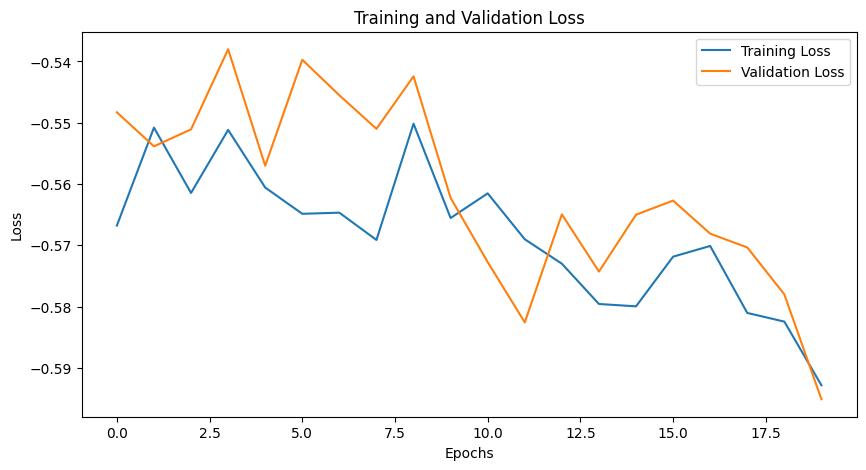

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

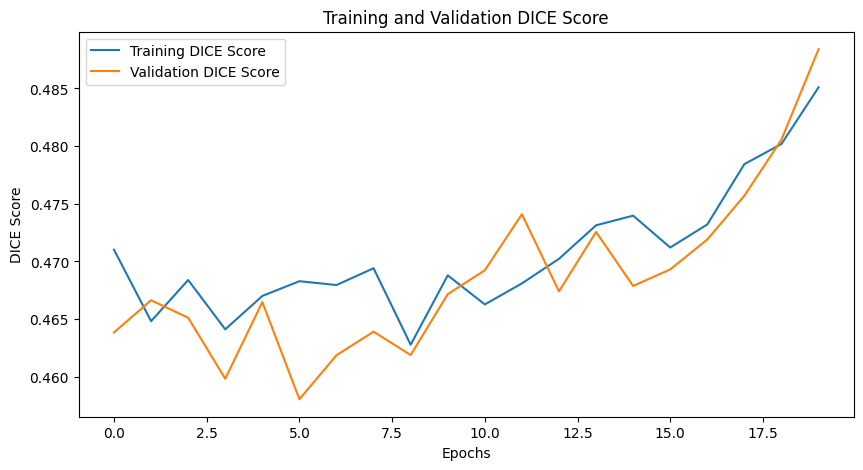

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_dice_scores, label='Training DICE Score')
plt.plot(val_dice_scores, label='Validation DICE Score')
plt.xlabel('Epochs')
plt.ylabel('DICE Score')
plt.title('Training and Validation DICE Score')
plt.legend()
plt.show()

# Plot registered Images

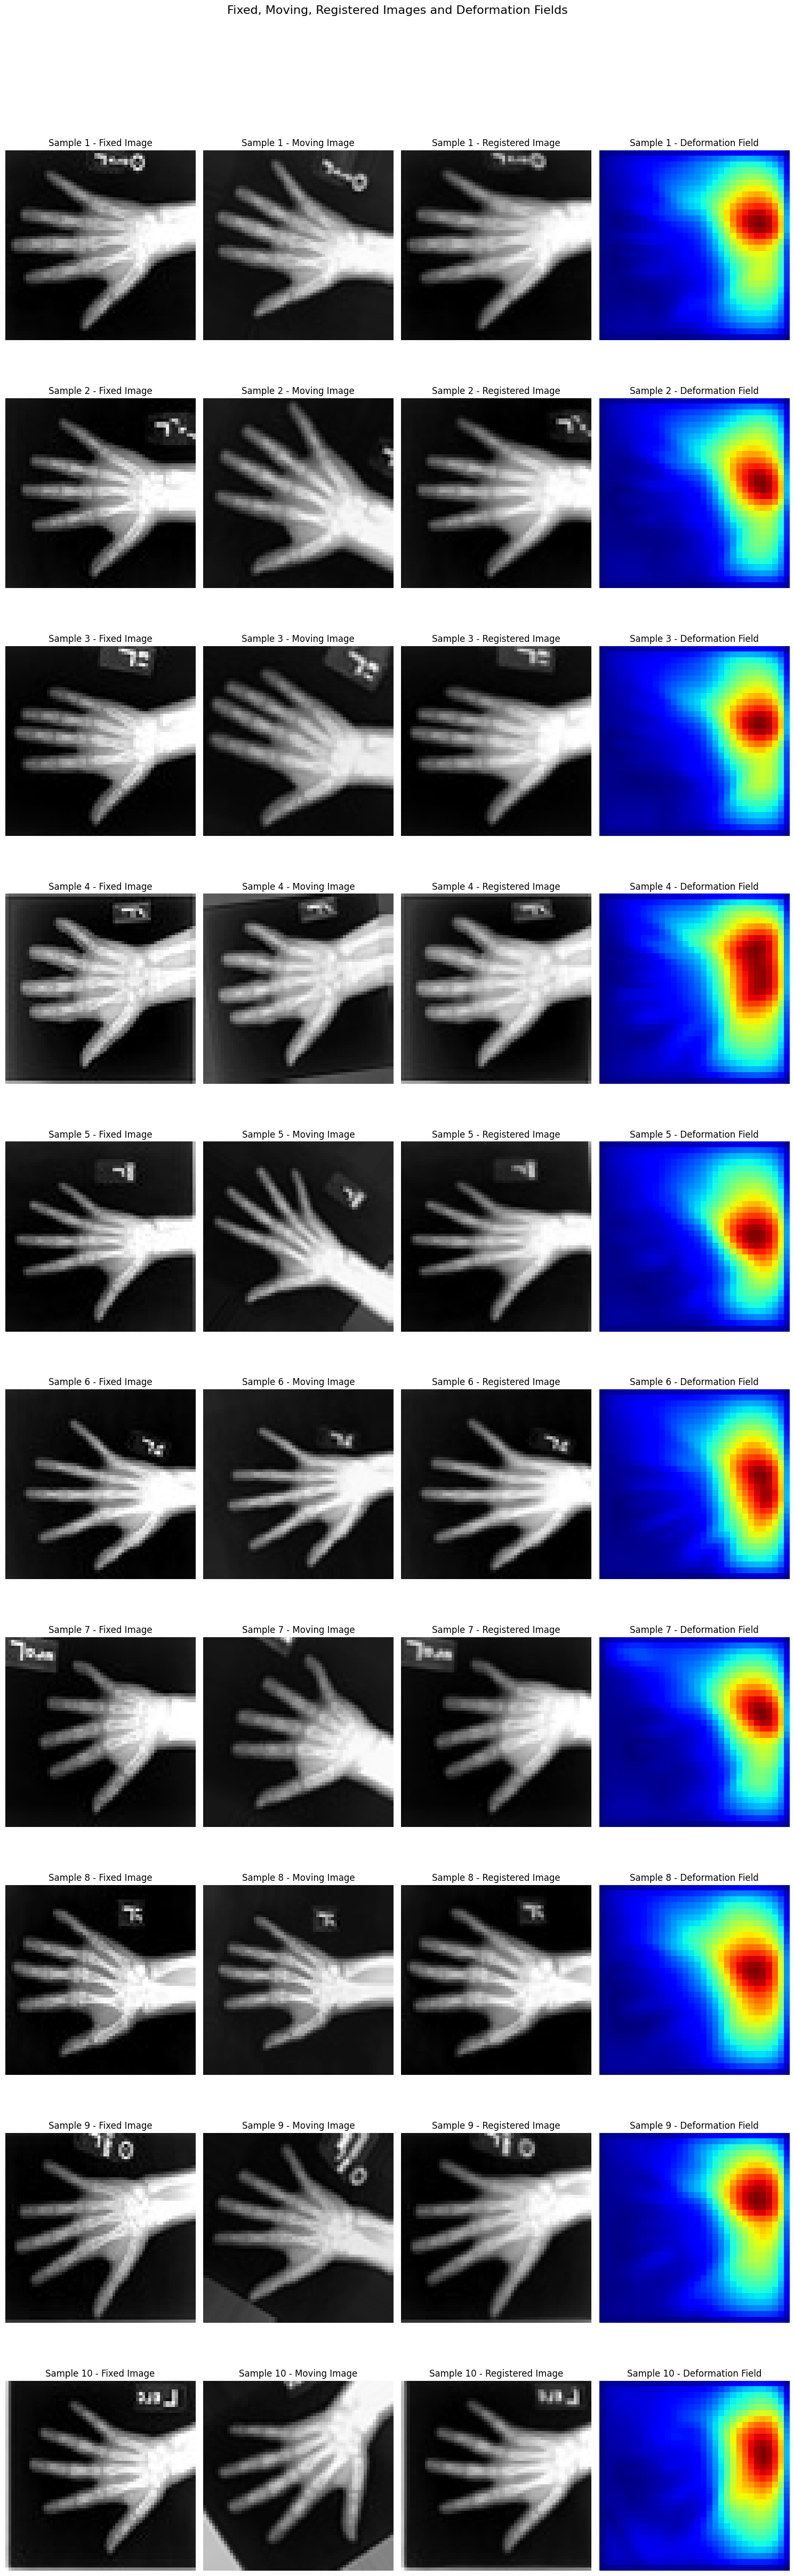

In [11]:
# TODO

def plot_samples(batch_fixed, batch_moving, registered_image, dff, k):
    """
    Plot k samples from batch_fixed, batch_moving, registered_image, and deformation matrix in the validation set.  
    """
    
    fig, axs = plt.subplots(k, 4, figsize=(15, 5 * k)) 

    
    #################################################################################
    #                         YOUR CODE GOES HERE              10 pts               #
    fig.suptitle('Fixed, Moving, Registered Images and Deformation Fields', fontsize=16)

    for i in range(k):
        fixed_sample = batch_fixed[i].cpu().numpy().squeeze()
        moving_sample = batch_moving[i].cpu().numpy().squeeze()
        registered_sample = registered_image[i].cpu().numpy().squeeze()
        deformation_field = dff[i].cpu().numpy()

        # Fixed Image
        axs[i, 0].imshow(fixed_sample, cmap='gray')
        axs[i, 0].set_title(f'Sample {i+1} - Fixed Image')
        axs[i, 0].axis('off')

        # Moving Image
        axs[i, 1].imshow(moving_sample, cmap='gray')
        axs[i, 1].set_title(f'Sample {i+1} - Moving Image')
        axs[i, 1].axis('off')

        # Registered Image
        axs[i, 2].imshow(registered_sample, cmap='gray')
        axs[i, 2].set_title(f'Sample {i+1} - Registered Image')
        axs[i, 2].axis('off')

        # Deformation Field
        deformation_magnitude = np.sqrt(np.sum(np.square(deformation_field), axis=0))
        axs[i, 3].imshow(deformation_magnitude, cmap='jet')
        axs[i, 3].set_title(f'Sample {i+1} - Deformation Field')
        axs[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
fixed = batch_fixed_full
moving = batch_moving_full
register = pred_full
dffs = dff_full
    #################################################################################

plot_samples(fixed, moving, register, dffs, k=10)